# < Deep Learning - PART3 TF2 RNNs >

# Ch 6. RNNs Workshop 6 - RNNs for Image Classification
2021/10/01

>**[ Reference ] :**

> + TensorFlow Core - Guide, **Recurrent Neural Networks (RNN) with Keras** https://www.tensorflow.org/guide/keras/rnn#build_a_simple_model 
> + Tom Hope, Yehezkel S. Resheff, and Itay Lieder, "**`Learning TensorFlow : A Guide to Building Deep Learning Systems`**", Chapter 4 & 6, O'Reilly, 2017. - [ Code ] : https://github.com/giser-yugang/Learning_TensorFlow
---

In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow.keras import layers

## Performance optimization and CuDNN kernels in TensorFlow 2.0

In TensorFlow 2.0, the built-in LSTM and GRU layers have been updated to leverage CuDNN kernels by default when a GPU is available. With this change, the prior `keras.layers.CuDNNLSTM/CuDNNGRU` layers have been deprecated, and you can build your model without worrying about the hardware it will run on.

Since the CuDNN kernel is built with certain assumptions, this means the layer **will not be able to use the CuDNN kernel if you change the defaults of the built-in LSTM or GRU layers**. E.g.:

- Changing the `activation` function from `tanh` to something else.
- Changing the `recurrent_activation` function from `sigmoid` to something else.
- Using `recurrent_dropout` > 0.
- Setting `unroll` to True, which forces LSTM/GRU to decompose the inner `tf.while_loop` into an unrolled `for` loop.
- Setting `use_bias` to False.
- Using masking when the input data is not strictly right padded (if the mask corresponds to strictly right padded data, CuDNN can still be used. This is the most common case).

For the detailed list of constraints, please see the documentation for the [LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM) and [GRU](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/GRU) layers.

### Using CuDNN kernels when available

Let's build a simple LSTM model to demonstrate the performance difference.

We'll use as input sequences the sequence of rows of MNIST digits (treating each row of pixels as a timestep), and we'll predict the digit's label.


In [2]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
# CuDNN is only available at the layer level, and not at the cell level.
# This means `LSTM(units)` will use the CuDNN kernel,
# while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
    # The LSTM layer with default options uses CuDNN.
        lstm_layer = tf.keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
    # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = tf.keras.layers.RNN(
            tf.keras.layers.LSTMCell(units),
            input_shape=(None, input_dim))
    
    model = tf.keras.models.Sequential([
      lstm_layer,
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(output_size)]
      )
    return model


### Load MNIST dataset

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

### Create a model instance and compile it
We choose `sparse_categorical_crossentropy` as the loss function for the model. The output of the model has shape of `[batch_size, 10]`. The target for the model is a integer vector, each of the integer is in the range of 0 to 9.

> #### Q:若未安裝 CuDNN kernel，是否可以執行下列已設定 
   `allow_cudnn_kernel=True` 的指令？


In [4]:
# Q:若未安裝 CuDNN kernel，是否可以執行下列 allow_cudnn_kernel=True 指令？
model = build_model(allow_cudnn_kernel=True)  

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer='sgd',
              metrics=['accuracy'])

In [5]:
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 24s 403us/sample - loss: 0.9658 - accuracy: 0.6895 - val_loss: 0.6058 - val_accuracy: 0.7820
Epoch 2/5
60000/60000 [==============================] - 28s 470us/sample - loss: 0.3870 - accuracy: 0.8840 - val_loss: 0.2879 - val_accuracy: 0.911633 - accura - - - ETA: 0s - loss: 0.3891 
Epoch 3/5
60000/60000 [==============================] - 32s 538us/sample - loss: 0.2613 - accuracy: 0.9221 - val_loss: 0.2654 - val_accuracy: 0.9207
Epoch 4/5
60000/60000 [==============================] - 38s 636us/sample - loss: 0.2084 - accuracy: 0.9373 - val_loss: 0.2377 - val_accuracy: 0.9266
Epoch 5/5
60000/60000 [==============================] - 46s 768us/sample - loss: 0.1760 - accuracy: 0.9479 - val_loss: 0.3027 - val_accuracy: 0.8978


### Build a new model without CuDNN kernel

In [6]:
slow_model = build_model(allow_cudnn_kernel=False)
slow_model.set_weights(model.get_weights())
slow_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                   optimizer='sgd', 
                   metrics=['accuracy'])
slow_model.fit(x_train, y_train, 
               validation_data=(x_test, y_test), 
               batch_size=batch_size,
               epochs=1)  # We only train for one epoch because it's slower.

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 62s 1ms/sample - loss: 0.1546 - accuracy: 0.9538 - val_loss: 0.1331 - val_accuracy: 0.9608


As you can see, the model built with CuDNN is much faster to train compared to the model that use the regular TensorFlow kernel.

The same CuDNN-enabled model can also be use to run inference in a CPU-only environment. The `tf.device` annotation below is just forcing the device placement. The model will run on CPU by default if no GPU is available.

You simply don't have to worry about the hardware you're running on anymore. Isn't that pretty cool?

Predicted result is: [5], target result is: 5


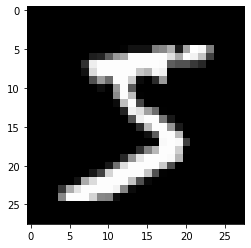

In [7]:
with tf.device('CPU:0'):
  cpu_model = build_model(allow_cudnn_kernel=True)
  cpu_model.set_weights(model.get_weights())
  result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
  print('Predicted result is: %s, target result is: %s' % (result.numpy(), sample_label))
  plt.imshow(sample, cmap=plt.get_cmap('gray'))